<a href="https://colab.research.google.com/github/dani2442/2026-Hybrid-Signal-Learning/blob/helon/Pedagogical_example_NODE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [3]:
#!pip install torchdiffeq
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lsim
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


# Generate mass spring damper data


In [ ]:
omega_n_true = 5.0
zeta_true = 0.5
gain_true = 1.0

# State-Space Matrices
A = np.array([[0, 1], [-(omega_n_true**2), -2 * zeta_true * omega_n_true]])
B = np.array([[0], [gain_true * (omega_n_true**2)]])
C = np.array([[1, 0], [0, 1]]) # Output both states
D = np.array([[0], [0]])

# Time and Input
dt = 0.01
t_duration = 5.0
t = np.arange(0, t_duration, dt)
u = np.zeros_like(t)

# Multisine Excitation
np.random.seed(42)
excitation_frequencies = np.linspace(0.1, 3.0 * omega_n_true, 30)
for freq in excitation_frequencies:
    u += 0.2 * np.sin(freq * t + np.random.uniform(0, 2 * np.pi))

# Simulate
x0_sim = np.array([0.0, 0.0])
t_sim, y_sim, x_out = lsim((A, B, C, D), u, t, X0=x0_sim)

# --- 5. Visualization ---
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(t, u, color='gray', alpha=0.5, label='Input u(t)')
plt.title(f'General 2nd Order System Simulation ($\omega_n$={omega_n_true}, $\zeta$={zeta_true})')
plt.ylabel('Input')
plt.grid(True)
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(t_sim, y_sim[:,0], color='tab:blue', label='position')
plt.plot(t_sim, y_sim[:,1], color='tab:red', label='velocity')
plt.xlabel('Time (s)')
plt.ylabel('Output')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

print("Simulation complete.")

## Define Neural ODE Model


Running on: cuda

--- Training Physics Model ---
Epoch 0 | Loss: 0.857261
Epoch 200 | Loss: 0.000000
Epoch 400 | Loss: 0.000000
 identified: wn=5.000, zeta=0.500

--- Training Black-Box Model ---
Epoch 0 | Loss: 0.796530
Epoch 200 | Loss: 0.000261
Epoch 400 | Loss: 0.000041

--- Running Full Data Simulation ---


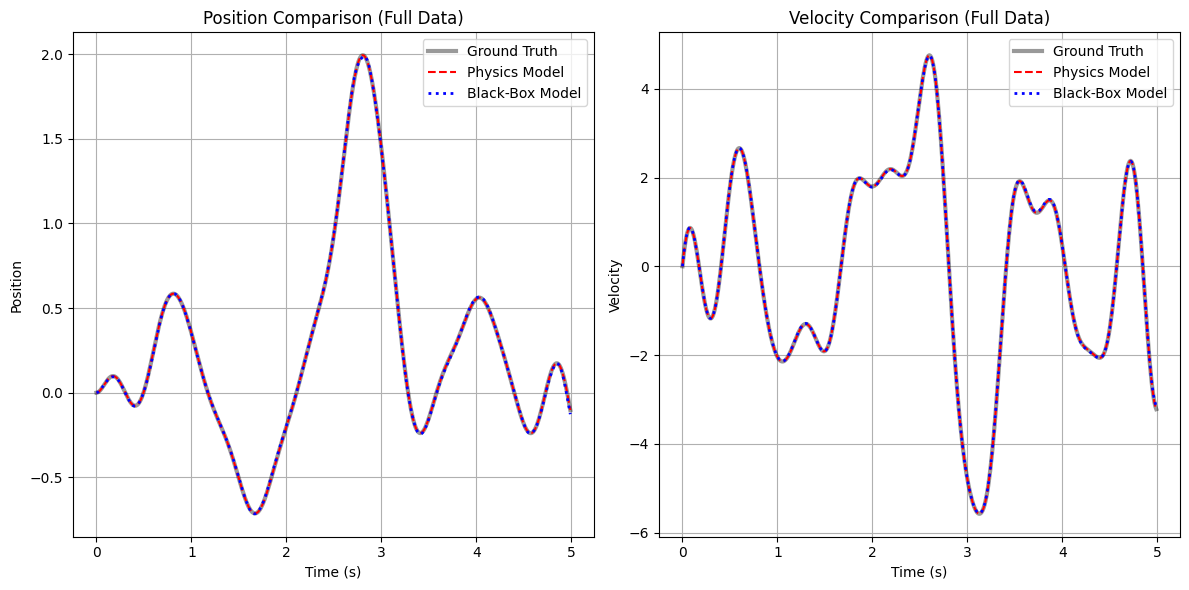

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# 0. SETUP & DATA PREP
# ==========================================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Running on: {device}")

# --- Prepare Tensors ---
t_tensor = torch.tensor(t, dtype=torch.float32).to(device)
u_tensor = torch.tensor(u, dtype=torch.float32).reshape(-1, 1).to(device)
y_tensor = torch.tensor(y_sim, dtype=torch.float32).to(device)

# ==========================================
# 1. MODEL DEFINITIONS (FIXED)
# ==========================================

# --- A. PHYSICS-INFORMED MODEL ---
class PhysicsODE(nn.Module):
    def __init__(self):
        super().__init__()
        self.log_wn = nn.Parameter(torch.tensor(0.0))
        self.log_zeta = nn.Parameter(torch.tensor(-1.0))
        self.log_gain = nn.Parameter(torch.tensor(0.0))
        self.u_series = None
        self.t_series = None
        self.batch_start_times = None

    def get_params(self):
        return torch.exp(self.log_wn), torch.exp(self.log_zeta), torch.exp(self.log_gain)

    def forward(self, t, x):
        wn, zeta, gain = self.get_params()

        # Time handling
        if self.batch_start_times is not None:
            t_abs = self.batch_start_times + t
        else:
            t_abs = t * torch.ones_like(x[:,0:1])

        # --- FIX: Use reshape(-1) to ensure we always have a 1D vector ---
        k = torch.searchsorted(self.t_series, t_abs.reshape(-1), right=True)
        k = torch.clamp(k, 1, len(self.t_series) - 1)

        # Now indexing returns a 1D tensor (even if size is 1), so unsqueeze(1) is safe
        t1, t2 = self.t_series[k-1].unsqueeze(1), self.t_series[k].unsqueeze(1)
        u1, u2 = self.u_series[k-1], self.u_series[k]

        denom = (t2 - t1)
        denom[denom < 1e-6] = 1.0
        alpha = (t_abs - t1) / denom
        u_t = u1 + alpha * (u2 - u1)

        # Dynamics
        pos, vel = x[:, 0:1], x[:, 1:2]
        d_pos = vel
        d_vel = -2 * zeta * wn * vel - (wn**2) * pos + (gain * wn**2) * u_t
        return torch.cat([d_pos, d_vel], dim=1)

# --- B. BLACK-BOX MODEL ---
class BlackBoxODE(nn.Module):
    def __init__(self, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 2)
        )
        self.u_series = None
        self.t_series = None
        self.batch_start_times = None

    def forward(self, t, x):
        if self.batch_start_times is not None:
            t_abs = self.batch_start_times + t
        else:
            t_abs = t * torch.ones_like(x[:,0:1])

        # --- FIX: Same fix here ---
        k = torch.searchsorted(self.t_series, t_abs.reshape(-1), right=True)
        k = torch.clamp(k, 1, len(self.t_series) - 1)

        t1, t2 = self.t_series[k-1].unsqueeze(1), self.t_series[k].unsqueeze(1)
        u1, u2 = self.u_series[k-1], self.u_series[k]

        denom = (t2 - t1)
        denom[denom < 1e-6] = 1.0
        alpha = (t_abs - t1) / denom
        u_t = u1 + alpha * (u2 - u1)

        nn_input = torch.cat([x, u_t], dim=1)
        return self.net(nn_input)

# ==========================================
# 2. TRAINING FUNCTION
# ==========================================
def train_model(model, name, epochs=1000, lr=0.02):
    print(f"\n--- Training {name} ---")
    model.to(device)
    model.u_series = u_tensor
    model.t_series = t_tensor

    optimizer = optim.Adam(model.parameters(), lr=lr)

    K_STEPS = 20
    BATCH_SIZE = 128
    dt = (t_tensor[1] - t_tensor[0]).item()
    t_eval = torch.arange(0, K_STEPS * dt, dt, device=device)

    for epoch in range(epochs + 1):
        optimizer.zero_grad()

        start_idx = np.random.randint(0, len(t_tensor) - K_STEPS, size=BATCH_SIZE)
        x0 = y_tensor[start_idx]
        model.batch_start_times = t_tensor[start_idx].reshape(-1, 1)

        pred_state = odeint(model, x0, t_eval, method='rk4')

        batch_targets = []
        for i in start_idx:
            batch_targets.append(y_tensor[i:i+K_STEPS])
        y_target = torch.stack(batch_targets, dim=1)

        loss = torch.mean((pred_state - y_target)**2)
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print(f"Epoch {epoch} | Loss: {loss.item():.6f}")

    return model

# ==========================================
# 3. EXECUTE TRAINING
# ==========================================
# A. Train Physics Model
phys_model = PhysicsODE()
phys_model = train_model(phys_model, "Physics Model", epochs=500, lr=0.05)
wn, zeta, _ = phys_model.get_params()
print(f" identified: wn={wn.item():.3f}, zeta={zeta.item():.3f}")

# B. Train Black Box Model
bb_model = BlackBoxODE(hidden_dim=64)
bb_model = train_model(bb_model, "Black-Box Model", epochs=500, lr=0.01)

# ==========================================
# 4. FULL SIMULATION & COMPARISON
# ==========================================
print("\n--- Running Full Data Simulation ---")

with torch.no_grad():
    # --- Simulate Physics Model ---
    # We must explicitly create a 2D tensor for start_time: (1 batch, 1 time)
    phys_model.batch_start_times = torch.zeros(1, 1).to(device)
    x0 = y_tensor[0].unsqueeze(0) # Shape (1, 2)

    full_pred_phys = odeint(phys_model, x0, t_tensor, method='rk4')
    full_pred_phys = full_pred_phys.squeeze(1).cpu().numpy()

    # --- Simulate Black Box Model ---
    bb_model.batch_start_times = torch.zeros(1, 1).to(device)

    full_pred_bb = odeint(bb_model, x0, t_tensor, method='rk4')
    full_pred_bb = full_pred_bb.squeeze(1).cpu().numpy()

# ==========================================
# 5. PLOTTING
# ==========================================
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(t, y_sim[:, 0], 'k-', alpha=0.4, linewidth=3, label='Ground Truth')
plt.plot(t, full_pred_phys[:, 0], 'r--', linewidth=1.5, label='Physics Model')
plt.plot(t, full_pred_bb[:, 0], 'b:', linewidth=2, label='Black-Box Model')
plt.title("Position Comparison (Full Data)")
plt.xlabel("Time (s)")
plt.ylabel("Position")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(t, y_sim[:, 1], 'k-', alpha=0.4, linewidth=3, label='Ground Truth')
plt.plot(t, full_pred_phys[:, 1], 'r--', linewidth=1.5, label='Physics Model')
plt.plot(t, full_pred_bb[:, 1], 'b:', linewidth=2, label='Black-Box Model')
plt.title("Velocity Comparison (Full Data)")
plt.xlabel("Time (s)")
plt.ylabel("Velocity")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()